**Implementación y Evaluación de un Modelo con SVM**

En este proyecto, implementamos y evaluamos un modelo SVM para clasificar muestras de sangre en función de si presentan enfermedades o no.

**Importación de Librerías**

Primero, importamos todas las bibliotecas necesarias para nuestro análisis. Esto incluye pandas y numpy para la manipulación de datos, sklearn para el aprendizaje automático y matplotlib para la visualización de datos.

In [19]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from scipy.stats import uniform, loguniform
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

**Carga de Datos**

Cargamos nuestros datos de un archivo CSV llamado ‘blood_samples.csv’. Separamos nuestras características (X) de nuestras etiquetas (y). Luego, dividimos nuestros datos en conjuntos de entrenamiento y prueba.

In [9]:
df_train = pd.read_csv('blood_samples.csv')
X = df_train.drop('Disease', axis=1)  # Caracteristicas
y = df_train['Disease']  # Etiquetas
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

**Evaluación del Modelo SVM**

Definimos una función para evaluar nuestro modelo SVM. Esta función entrena el modelo, realiza predicciones en el conjunto de prueba y luego imprime un informe de clasificación. También realiza una validación cruzada si se especifica.

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn import svm
import numpy as np

def evaluate_svm(x_train, y_train, x_test, y_test, kernel='poly', do_cross_validation=True):

    model = svm.SVC(kernel=kernel)
    model.fit(x_train, y_train)

    predictions = model.predict(x_test)

    print("Reporte de clasificación:\n", classification_report(y_test, predictions))

    if do_cross_validation:
        cv = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')  # Número de iteraciones = 5

        print("Resultados de validación cruzada:")
        for i, accuracy in enumerate(cv):
            print(f"Iteración {i+1}: Accuracy = {accuracy}")

        print(f"Accuracy promedio: {np.mean(cv)}")
        print(f"Desviación estándar del accuracy: {np.std(cv)}")

    cm = confusion_matrix(y_test, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    report = classification_report(y_test, predictions, output_dict=True)
    classes = list(report.keys())[:-3]
    metrics = ['precision', 'recall', 'f1-score']

    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(classes))
    width = 0.2

    for i, metric in enumerate(metrics):
        values = [report[key][metric] for key in classes]
        ax.bar(x + width * i, values, width, label=metric)

    ax.set_ylabel('Metricas')
    ax.set_title('Metricas de clasificacion')
    ax.set_xticks(x + width)
    ax.set_xticklabels(classes)
    ax.legend()
    plt.tight_layout()
    plt.show()


**Prueba de Diferentes Kernels**

Probamos diferentes kernels para ver cuál proporciona los mejores resultados. Probamos los kernels ‘linear’, ‘poly’ y ‘rbf’.

Reporte de clasificación:
               precision    recall  f1-score   support

      Anemia       0.89      0.92      0.91       137
    Diabetes       0.82      0.83      0.83       164
     Healthy       0.91      0.97      0.94       122
    Heart Di       0.00      0.00      0.00         7
    Thalasse       0.89      0.83      0.86       102
    Thromboc       0.94      0.94      0.94        36

    accuracy                           0.88       568
   macro avg       0.74      0.75      0.75       568
weighted avg       0.87      0.88      0.87       568



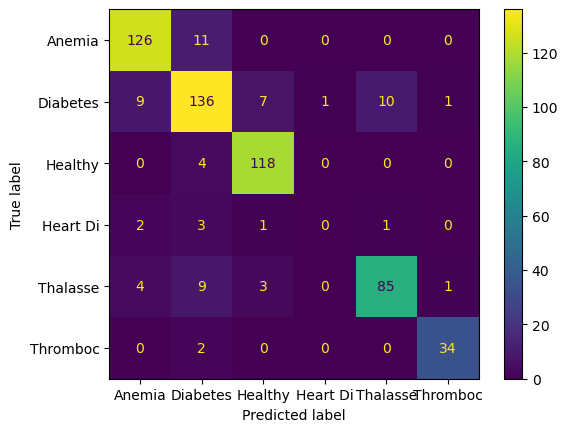

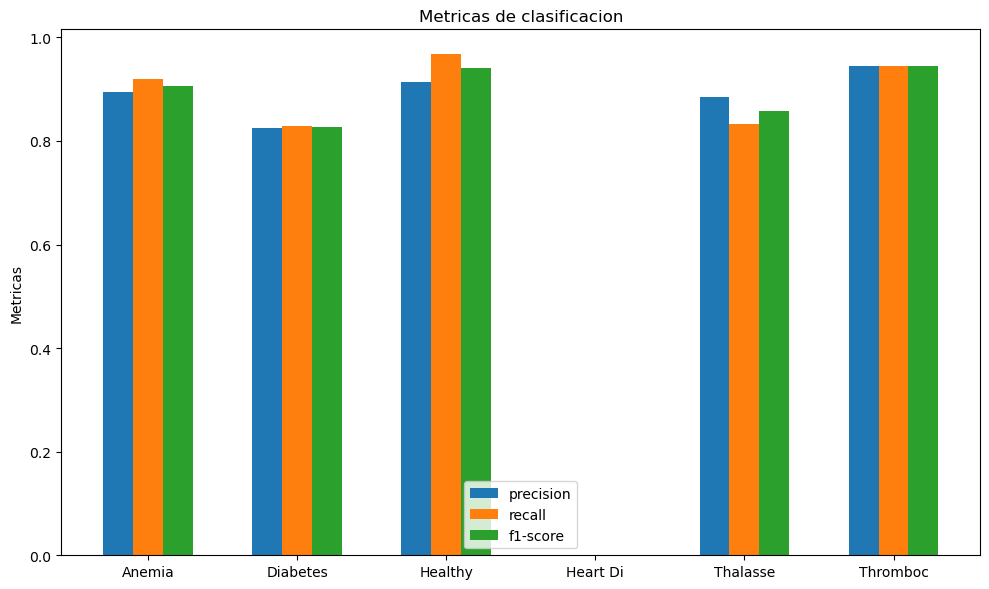

In [11]:
evaluate_svm(x_train, y_train, x_test, y_test, kernel='linear', do_cross_validation=False)

Reporte de clasificación:
               precision    recall  f1-score   support

      Anemia       0.88      0.96      0.92       137
    Diabetes       0.94      0.88      0.91       164
     Healthy       0.96      0.98      0.97       122
    Heart Di       0.50      0.14      0.22         7
    Thalasse       0.93      0.93      0.93       102
    Thromboc       0.97      0.97      0.97        36

    accuracy                           0.93       568
   macro avg       0.86      0.81      0.82       568
weighted avg       0.92      0.93      0.92       568

Resultados de validación cruzada:
Iteración 1: Accuracy = 0.9295154185022027
Iteración 2: Accuracy = 0.9317180616740088
Iteración 3: Accuracy = 0.9405286343612335
Iteración 4: Accuracy = 0.9251101321585903
Iteración 5: Accuracy = 0.9426048565121413
Accuracy promedio: 0.9338954206416353
Desviación estándar del accuracy: 0.006647712418238076


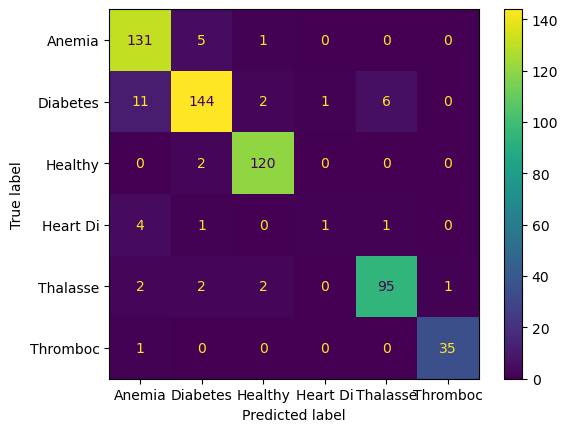

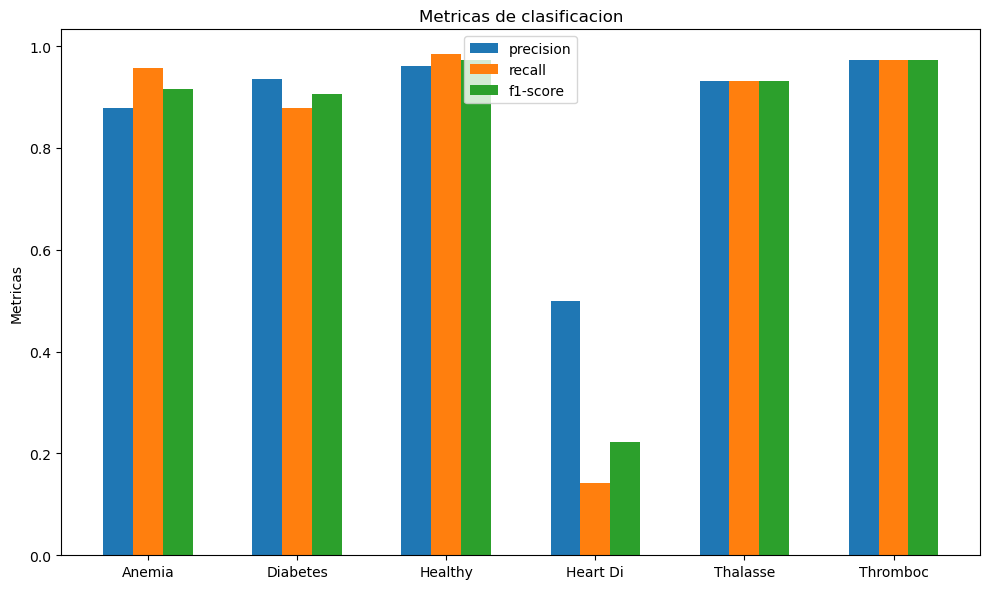

In [12]:
evaluate_svm(x_train, y_train, x_test, y_test, kernel='poly', do_cross_validation=True)

Reporte de clasificación:
               precision    recall  f1-score   support

      Anemia       0.93      0.91      0.92       137
    Diabetes       0.87      0.97      0.92       164
     Healthy       0.99      0.99      0.99       122
    Heart Di       0.00      0.00      0.00         7
    Thalasse       0.98      0.92      0.95       102
    Thromboc       1.00      0.92      0.96        36

    accuracy                           0.94       568
   macro avg       0.80      0.79      0.79       568
weighted avg       0.93      0.94      0.93       568



c:\Users\luisb\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\luisb\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\luisb\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


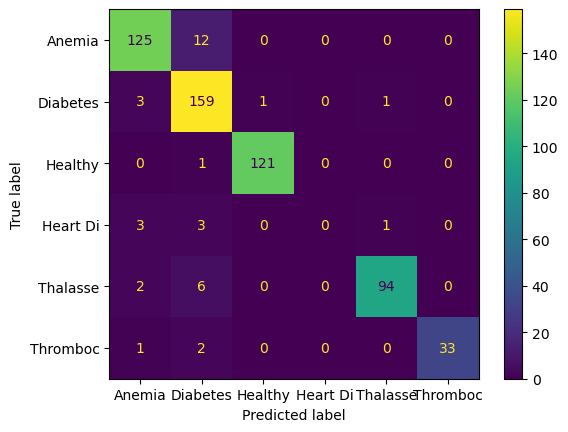

c:\Users\luisb\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\luisb\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\luisb\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


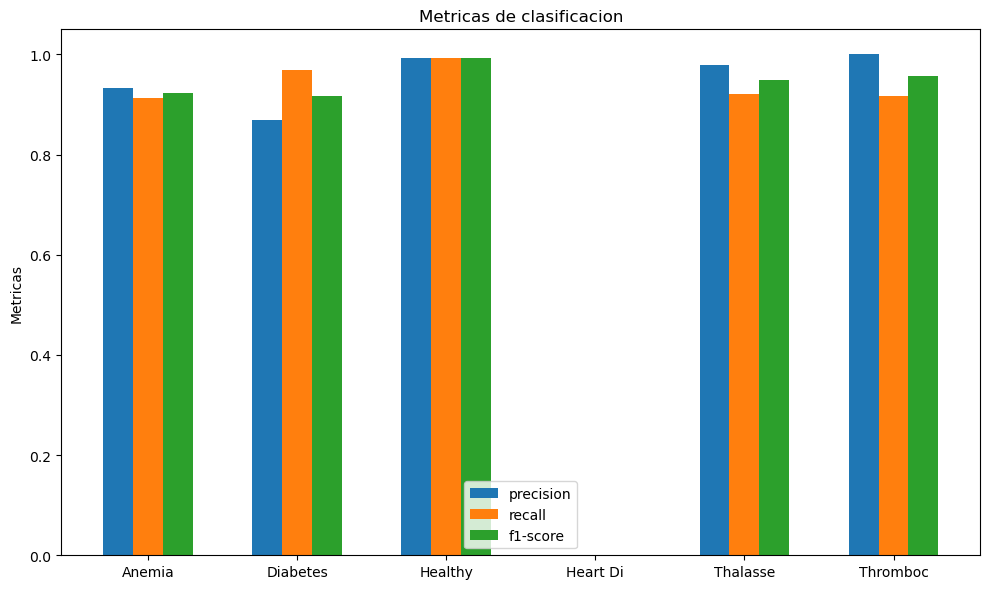

In [13]:
evaluate_svm(x_train, y_train, x_test, y_test, kernel='rbf', do_cross_validation=False)

**Optimización de Hiperparámetros**

Utilizamos RandomizedSearchCV y GridSearchCV para optimizar los hiperparámetros de nuestro modelo SVM. Estos métodos prueban diferentes combinaciones de hiperparámetros y seleccionan la combinación que produce la mayor precisión.


El código optimiza, entrena y evalúa un modelo de Máquinas de Vectores de Soporte (SVM) con visualización comparativa de la precisión para diferentes parámetros. Se realizan los siguientes pasos:

**Ajuste de hiperparámetros (Randomized Search CV):**

Se define un espacio de búsqueda para los hiperparámetros del SVM (kernel, C, gamma, etc.).
El modelo SVM se entrena con diferentes combinaciones de hiperparámetros utilizando validación cruzada y se evalúa su precisión.
Se encuentra la mejor configuración de hiperparámetros según la mayor precisión media.

**Entrenamiento y evaluación:**

Se crea un modelo SVM final con los mejores hiperparámetros.
El modelo final se entrena en los datos de entrenamiento.
Se realizan predicciones en los datos de prueba.
Se evalúa el rendimiento del modelo mediante un informe de clasificación y una matriz de confusión.

Mejores parámetros: {'C': 6.461455513920145, 'cache_size': 100, 'class_weight': 'balanced', 'coef0': -0.8885610932628255, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 0.15730262902203, 'kernel': 'rbf', 'max_iter': 1000, 'probability': False, 'shrinking': True, 'tol': 0.00014796116656799012, 'verbose': 0}
Mejor puntaje: 0.9387441530277835
Reporte de clasificación:
               precision    recall  f1-score   support

      Anemia       0.91      0.93      0.92       137
    Diabetes       0.90      0.90      0.90       164
     Healthy       0.98      0.99      0.98       122
    Heart Di       0.75      0.43      0.55         7
    Thalasse       0.93      0.94      0.94       102
    Thromboc       1.00      0.97      0.99        36

    accuracy                           0.93       568
   macro avg       0.91      0.86      0.88       568
weighted avg       0.93      0.93      0.93       568



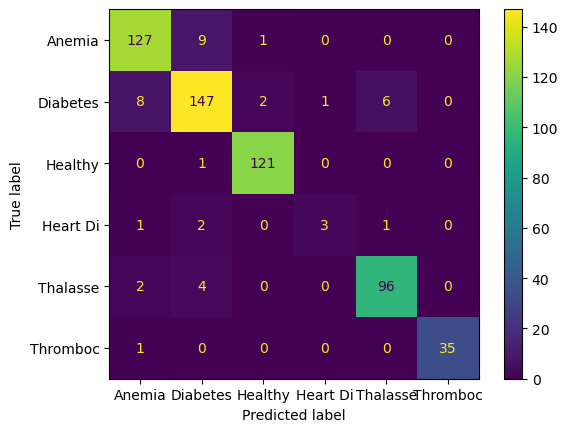

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    param_distributions = {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': loguniform(0.001, 100.0),
        'gamma': loguniform(0.00001, 1.0),
        'degree': [2, 3, 4, 5],
        'coef0': uniform(-1.0, 1.0),
        'shrinking': [True, False],
        'probability': [True, False],
        'tol': loguniform(1e-6, 1e-2),
        'cache_size': [100, 200, 500],
        'class_weight': ['balanced', None],
        'verbose': [0],
        'max_iter': [1000, 2000, 5000],
        'decision_function_shape': ['ovo', 'ovr'],
    }

    model = svm.SVC()

    random_search = RandomizedSearchCV(model, param_distributions, n_iter=100, cv=5, scoring='accuracy', n_jobs=8)

    random_search.fit(x_train, y_train)

    best_params = random_search.best_params_

    print("Mejores parámetros:", best_params)
    print("Mejor puntaje:", random_search.best_score_)

    best_model = svm.SVC(**best_params)
    best_model.fit(x_train, y_train)

    predictions = best_model.predict(x_test)
    print("Reporte de clasificación:\n", classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions, labels = best_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = best_model.classes_)
    disp.plot()
    plt.show()

Ploteamos los distintos parametros en relaccion a su accuracy, pero como RandomizedSearchCV mezcla los parametros de manera aleatoria, los graficos no tendran una relaccion consistente.

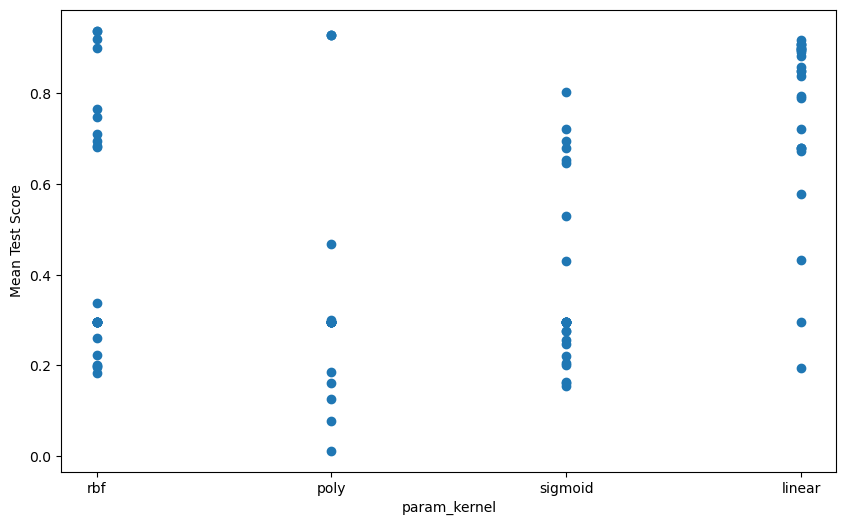

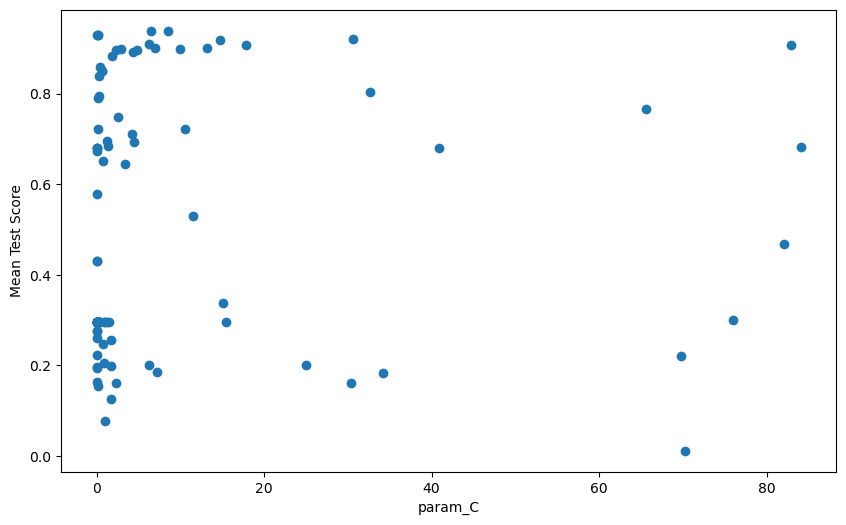

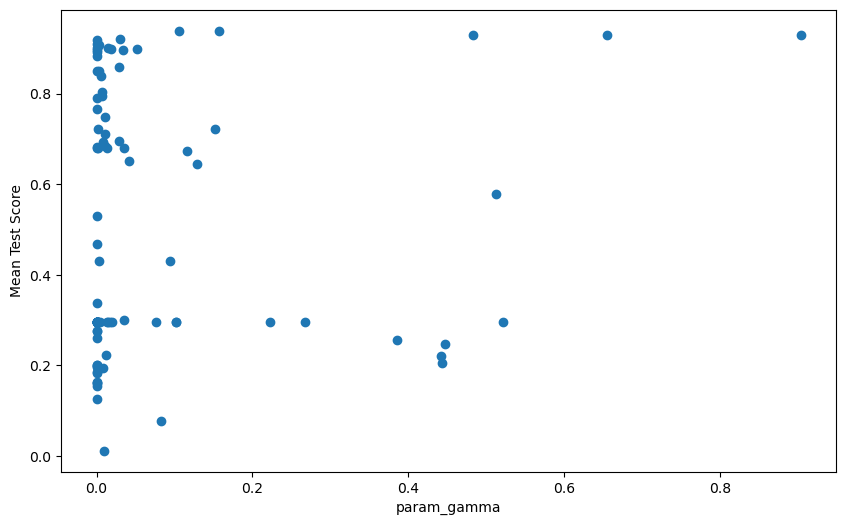

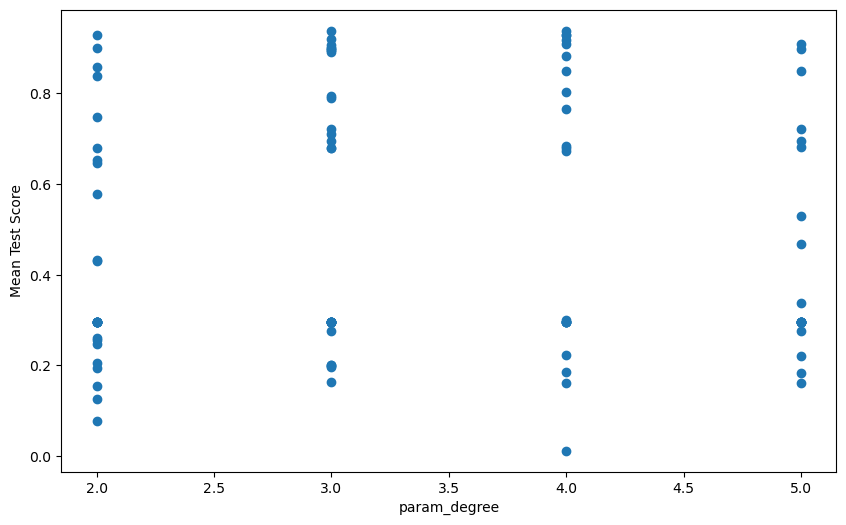

In [15]:
df_random = pd.DataFrame(random_search.cv_results_)

params_of_interest = ['param_kernel', 'param_C', 'param_gamma', 'param_degree']

for param in params_of_interest:
    plt.figure(figsize=(10, 6))
    # Filtrar el DataFrame para eliminar las filas donde el parámetro es None
    filtered_df = df_random[df_random[param].notna()]
    plt.plot(filtered_df[param], filtered_df['mean_test_score'], 'o')
    plt.xlabel(param)
    plt.ylabel('Mean Test Score')
    plt.show()

Volvermos a hacer la busqueda pero con GridSearchCV para que la busqueda sea mas exhaustiva y consistente en los parametros que con RandomizedSearchCV 

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    param_grid = {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': np.logspace(-3, 2, 6),
        'gamma': np.logspace(-5, 0, 6),
        'degree': [2, 3],
        'shrinking': [True],
        'probability': [True],
        'class_weight': [None],
        'verbose': [0],
        'max_iter': [1000],
        'decision_function_shape': ['ovr'],
    }

    model = svm.SVC()

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=8)

    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_

    print("Mejores parámetros:", best_params)
    print("Mejor puntaje:", grid_search.best_score_)

    best_model = svm.SVC(**best_params)
    best_model.fit(x_train, y_train)

    predictions = best_model.predict(x_test)
    print("Reporte de clasificación:\n", classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions, labels = best_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = best_model.classes_)
    disp.plot()
    plt.show()


KeyboardInterrupt: 

In [ ]:
df_grid = pd.DataFrame(grid_search.cv_results_)

params_of_interest = ['param_kernel', 'param_C', 'param_gamma', 'param_degree']

for param in params_of_interest:
    plt.figure(figsize=(10, 6))
    filtered_df = df_grid[df_grid[param].notna()]
    plt.plot(filtered_df[param], filtered_df['mean_test_score'], 'o')
    plt.xlabel(param)
    plt.ylabel('Mean Test Score')
    plt.show()

Resultados con RandomizedSearchCV

    Mejores parámetros: {
        'C': 96.39636288596346,
        'cache_size': 200,
        'class_weight': 'balanced',
        'coef0': -0.6719290189526498,
        'decision_function_shape': 'ovo',
        'degree': 4,
        'gamma': 0.32329765890129275,
        'kernel': 'rbf',
        'max_iter': 2000,
        'probability': True,
        'shrinking': True,
        'tol': 0.00025189034577900667,
        'verbose': 0
        }

    Mejor puntaje: 0.9435909404751486
    
Resultados con GridSearchCV

    Mejores parámetros: {
        'C': 10.0,
        'class_weight': None,
        'decision_function_shape': 'ovr',
        'degree': 2,
        'gamma': 1.0,
        'kernel': 'rbf',
        'max_iter': 1000,
        'probability': True,
        'shrinking': True,
        'verbose': 0
        }
        
    Mejor puntaje: 0.9418268809989205

**Validación Cruzada Estratificada**

Realizamos una validación cruzada estratificada para evaluar la robustez de nuestro modelo. Esto implica dividir nuestros datos en diferentes particiones de manera que cada partición tenga aproximadamente la misma proporción de clases que los datos originales.

La función `stratified_cross_validation` realiza una validación cruzada estratificada en un conjunto de datos utilizando un modelo SVC, y como previamente hemos sacado los hiperparametros optimos usare esos

In [ ]:
def stratified_cross_validation(X, y, model, n_splits=5):
    
    skf = StratifiedKFold(n_splits=n_splits)

    accuracies = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        accuracy = accuracy_score(y_test, predictions)

        accuracies.append(accuracy)
        
    print(f"Precision por particion: {accuracies}")
    print(f"Precision media: {np.mean(accuracies)}")
    print(f"Desviacion estandar de la precision: {np.std(accuracies)}")


In [ ]:
model = SVC(C=10.0,class_weight=None,decision_function_shape='ovr',degree=2,gamma=1.0,kernel='rbf',max_iter=1000,probability=True,shrinking=True)
accuracies = stratified_cross_validation(X, y, model)

**Precisión por partición**: Rendimiento bueno en las 3 primeras particiones pero disminuye en los 2 últimos. Esto podría indicar que mi modelo está sobreajustando ciertas partes de los datos y no generaliza bien a otras partes.

**Precisión media**: El modelo fue correcto un 92% de las veces en las particiones.

**Desviación estándar de la precisión**: La desviación estándar es de 0.10, lo que indica que hubo una variabilidad del 10% en las precisiones de las particiones.


**Curva ROC**

Finalmente, trazamos la Curva de Característica Operativa del Receptor (ROC) para evaluar el rendimiento de nuestro modelo. La curva ROC es una gráfica que muestra la tasa de verdaderos positivos en función de la tasa de falsos positivos para diferentes umbrales de clasificación.

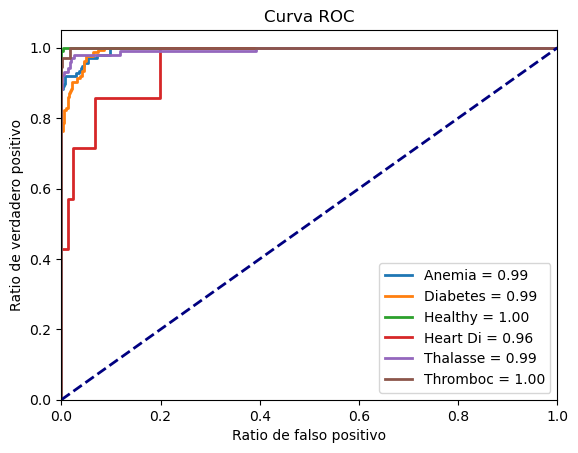

In [17]:
best_model = SVC(C=10.0,class_weight=None,decision_function_shape='ovr',degree=2,gamma=1.0,kernel='rbf',max_iter=1000,probability=True,shrinking=True)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
best_model.fit(x_train, y_train)
y_score = best_model.predict_proba(x_test)

fpr = []
tpr = []
roc_auc = []
lw=2

for i, class_name in enumerate(np.unique(y_test)):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc_i = auc(fpr_i, tpr_i)
    fpr.append(fpr_i)
    tpr.append(tpr_i)
    roc_auc.append(roc_auc_i)

    plt.plot(fpr_i, tpr_i, lw=lw, label='{0} = {1:0.2f}'.format(class_name, roc_auc_i))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio de falso positivo')
plt.ylabel('Ratio de verdadero positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

**Estos valores indican que el modelo tiene un excelente rendimiento en la clasificación de las clases**, ya que los valores AUC están muy cerca de 1, que es el valor óptimo. Un valor AUC de 1 significa que el modelo tiene una capacidad muy buena para distinguir entre la clase en cuestión y las demás clases. Un valor AUC de 0.5, representado por la línea diagonal punteada, indicaría que el modelo no tiene ninguna capacidad de clasificación más allá de la aleatoriedad. **Por lo tanto, los valores AUC cercanos a 1 son muy buenos**.


**Pruebas de robustez**

Vamos a realizar pruebas de robustez para ver como se comporta el modelo ante cambios pequeños en los datos de entrada.

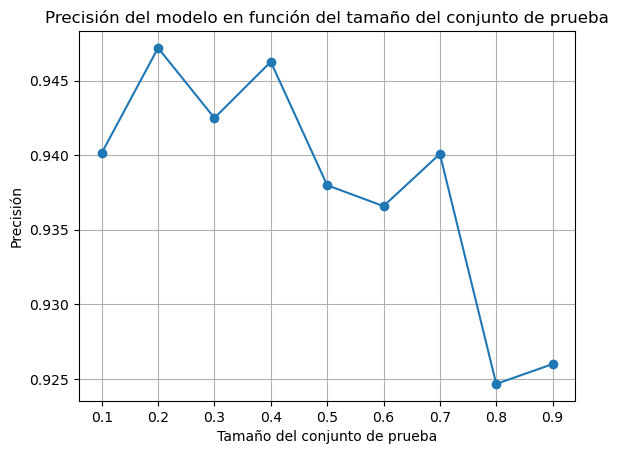

In [22]:
test_sizes = np.arange(0.1, 1.0, 0.1)
accuracies = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

plt.plot(test_sizes, accuracies, marker='o')
plt.title('Precisión del modelo en funcion del tamaño del conjunto de prueba')
plt.xlabel('Tamaño del conjunto de prueba')
plt.ylabel('Precisión')
plt.grid(True)
plt.show()

**Con un tamaño de prueba del 10%** (es decir, el 90% de los datos se utilizan para el entrenamiento), la precision del modelo es del 94.01%.

**Con un tamaño de prueba del 20%,** la precision aumenta ligeramente a 94.72%.

**Con un tamaño de prueba del 30%,** la precision disminuye un poco a 94.25%.

**Con un tamaño de prueba del 40%,** la precision es del 94.63%.

**Con un tamaño de prueba del 50%,** la precision disminuye a 93.80%.

**Con un tamaño de prueba del 60%,** la precision disminuye aun mas a 93.66%.

**Con un tamaño de prueba del 70%,** la precision aumenta ligeramente a 94.01%.

**Con un tamaño de prueba del 80%,** la precision disminuye significativamente a 92.47%.

**Con un tamaño de prueba del 90%,** la precision aumenta ligeramente a 92.60%.


En general, estos resultados sugieren que el modelo tiene un rendimiento bastante robusto, ya que la precision se mantiene en torno al 94% para la mayoria de los tamaños de prueba. Sin embargo, hay una disminucion notable en la precision cuando el tamaño de la prueba aumenta al 80% y 90%. Esto podria indicar que el modelo se beneficia de tener mas datos para el entrenamiento y podria tener dificultades para generalizar bien cuando se entrena con menos datos.